# REMDのトラジェクトリ解析

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import csv
from io import StringIO
import mdtraj as md
from tqdm.notebook import tqdm
from scipy.stats import gaussian_kde
import math
import scipy as sp
from scipy.ndimage import gaussian_filter

In [2]:
# https://zenn.dev/bluepost/articles/1b7b580ab54e95
import math
import numpy as np

# xxに対してsize個での移動平均を取る
def valid_convolve(xx, size):
    b = np.ones(size)/size
    xx_mean = np.convolve(xx, b, mode="same")

    n_conv = math.ceil(size/2)

    # 補正部分
    xx_mean[0] *= size/n_conv
    for i in range(1, n_conv):
        xx_mean[i] *= size/(i+n_conv)
        xx_mean[-i] *= size/(i + n_conv - (size % 2)) 
	# size%2は奇数偶数での違いに対応するため

    return xx_mean

## パラメータファイル読み込み

In [16]:
output_dir = './output/output_2024-12-09_17-39-54'
top = '/data2/yingh/replica_exchange/structures/ala2_solvated.pdb'

In [17]:
encoding = "utf-8"	# 読み込むファイルのエンコードによって適宜変える。
filepath = f'{output_dir}/params.json'
with open(filepath, mode="rt", encoding="utf-8") as f:
	params = json.load(f)		# JSONのファイル内容をdictに変換する。
print(params)

{'n_replicas': 8, 'temperature_min': 300, 'temperature_max': 500, 'temperatures': [300.0, 328.57142857142856, 357.14285714285717, 385.7142857142857, 414.2857142857143, 442.8571428571429, 471.42857142857144, 500.0], 'old_temperatures': [300.0, 328.57142857142856, 357.14285714285717, 385.7142857142857, 414.2857142857143, 442.8571428571429, 471.42857142857144, 500.0], 'acceptance_ratio': 0.25, 'dt': 0.002, 'n_steps': 1000000, 'n_steps_exchange': 1000, 'n_steps_save': 500, 'n_steps_equil': 25000, 'adjust_interval': 20, 'n_steps_adjust': 20000, 'learning_rate': 0.1, 'n_times_exchange': 1000, 'nonbondedCutoff': 1.0, 'friction': 1.0, 'restraint_force': 10, 'pdb_path': './structures/ala2_solvated.pdb', 'ff': ['amber99sbildn.xml', 'tip3p.xml']}


## ログファイルの読み込み

In [18]:
# 読み込まない行を指定
exception = ("Restarting", "Equilibrating", "Running","#")
# Dataframeの列名を指定
column_names = ["progress", "step", "potential_energy", 
                "temperature", "speed", "elapsed_time"]

In [19]:
dfs = []
for i in range(0, params['n_replicas'], 1):
    # ファイル名指定
    file_name = f'{output_dir}/replica_{i}.log'
    
    # データの読み込み（不要な行を除外）
    with open(file_name, 'r') as file:
        # ファイルを行ごとに処理して不要な行を除外
        lines = [line for line in file if not line.startswith(exception)]
        lines = [line.lstrip("#") for line in lines]
    
    # リストからデータフレームを読み込む
    df = pd.read_csv(
        StringIO("".join(lines)),  # 必要な行だけを文字列として渡す
        comment='#',              # コメント行を無視
        header=0,                  # ヘッダーを使用
        names=column_names
    )
    dfs.append(df)
    # データの確認
    # print(df)

combined_df = pd.concat(dfs, keys=np.arange(params['n_replicas']))

In [20]:
combined_df.loc[0] # 0番目のdfを取り出す

,progress,step,potential_energy,temperature,speed,elapsed_time
0,0.1%,1000,-9076.084161,298.018696,2060.0,0.041921
1,0.1%,1500,-8939.293617,288.985139,191.0,0.902885
2,0.2%,2000,-9230.291599,307.284846,273.0,0.949377
3,0.2%,2500,-8994.992253,302.024265,215.0,1.611212
4,0.3%,3000,-9149.731097,302.811819,262.0,1.650634
...,...,...,...,...,...,...
986,49.4%,494000,-9162.210110,297.382884,256.0,332.898890
987,49.5%,494500,-9088.082945,291.754969,256.0,333.594575
988,49.5%,495000,-8999.118830,308.453813,256.0,333.634377
989,49.5%,495500,-9025.455073,304.751637,256.0,334.242399


## 温度をplot

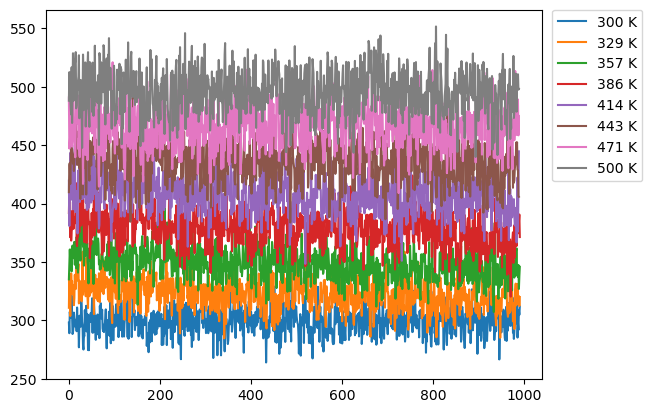

In [21]:
for i, temp in enumerate(params['temperatures']):
    plt.plot(combined_df.loc[i]['temperature'], label=f'{temp:.0f} K')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=10)
# plt.tight_layout()
plt.show()

### 更新された温度の推移

In [ ]:
adjusted_temperatures = pd.read_csv(f'{output_dir}/adjusted_temperatures.csv', header=0)
adjusted_temperatures.head()

,step,0,1,2,3,4,5,6,7
0,20000,300.0,327.790974,356.345138,385.209203,413.817176,442.363274,471.273747,499.792287
1,40000,300.0,327.033592,355.548456,384.407497,413.027194,441.892479,471.117125,499.640231
2,60000,300.0,326.298507,355.071019,383.931682,412.558220,441.735435,470.960497,499.184254
3,80000,300.0,325.584974,354.910309,383.148421,412.083758,441.894418,471.115438,499.035592
4,100000,300.0,324.892277,354.092411,382.364023,411.284567,442.058920,471.270321,498.594966


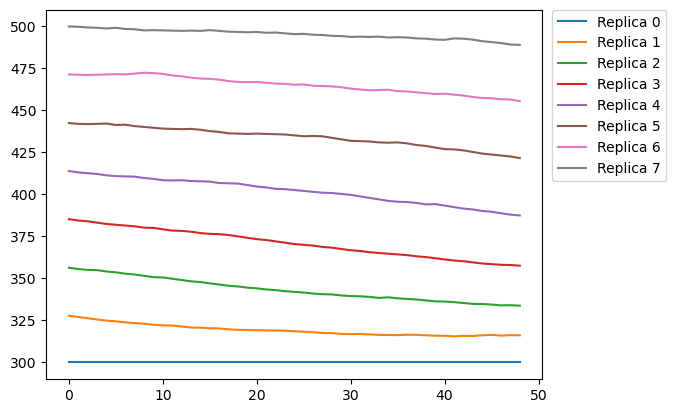

In [ ]:
for i in range(params['n_replicas']):
    plt.plot(adjusted_temperatures[str(i)], label=f'Replica {i}')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=10)
# plt.tight_layout()
plt.show()

## トラジェクトリを追跡

In [23]:
replicas = pd.read_csv(f'{output_dir}/replicas.csv', header=0)
print(replicas)

       step  0  1  2  3  4  5  6  7
0         0  0  1  2  3  4  5  6  7
1      1000  0  1  2  3  4  5  6  7
2      2000  0  1  2  3  4  5  6  7
3      3000  0  1  2  3  4  6  5  7
4      4000  0  1  2  3  4  6  5  7
..      ... .. .. .. .. .. .. .. ..
511  511000  1  2  3  0  7  5  4  6
512  512000  1  2  3  0  7  5  4  6
513  513000  1  2  3  0  7  5  4  6
514  514000  1  2  3  0  7  5  6  4
515  515000  1  3  2  0  7  5  6  4

[516 rows x 9 columns]


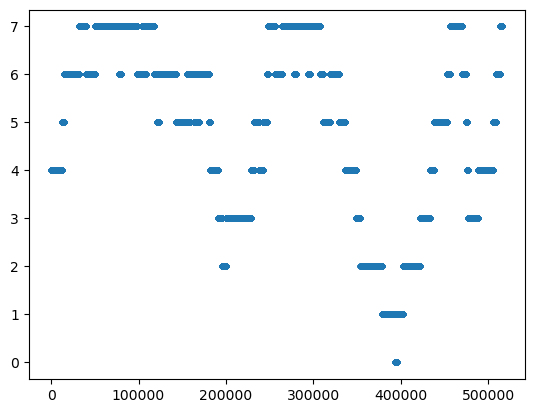

In [37]:
rep4 = np.where(replicas.to_numpy()==4)[1].repeat(params['n_steps_exchange']) - 1
plt.plot(rep4, '.')

/tmp/ipykernel_1538640/3538422245.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


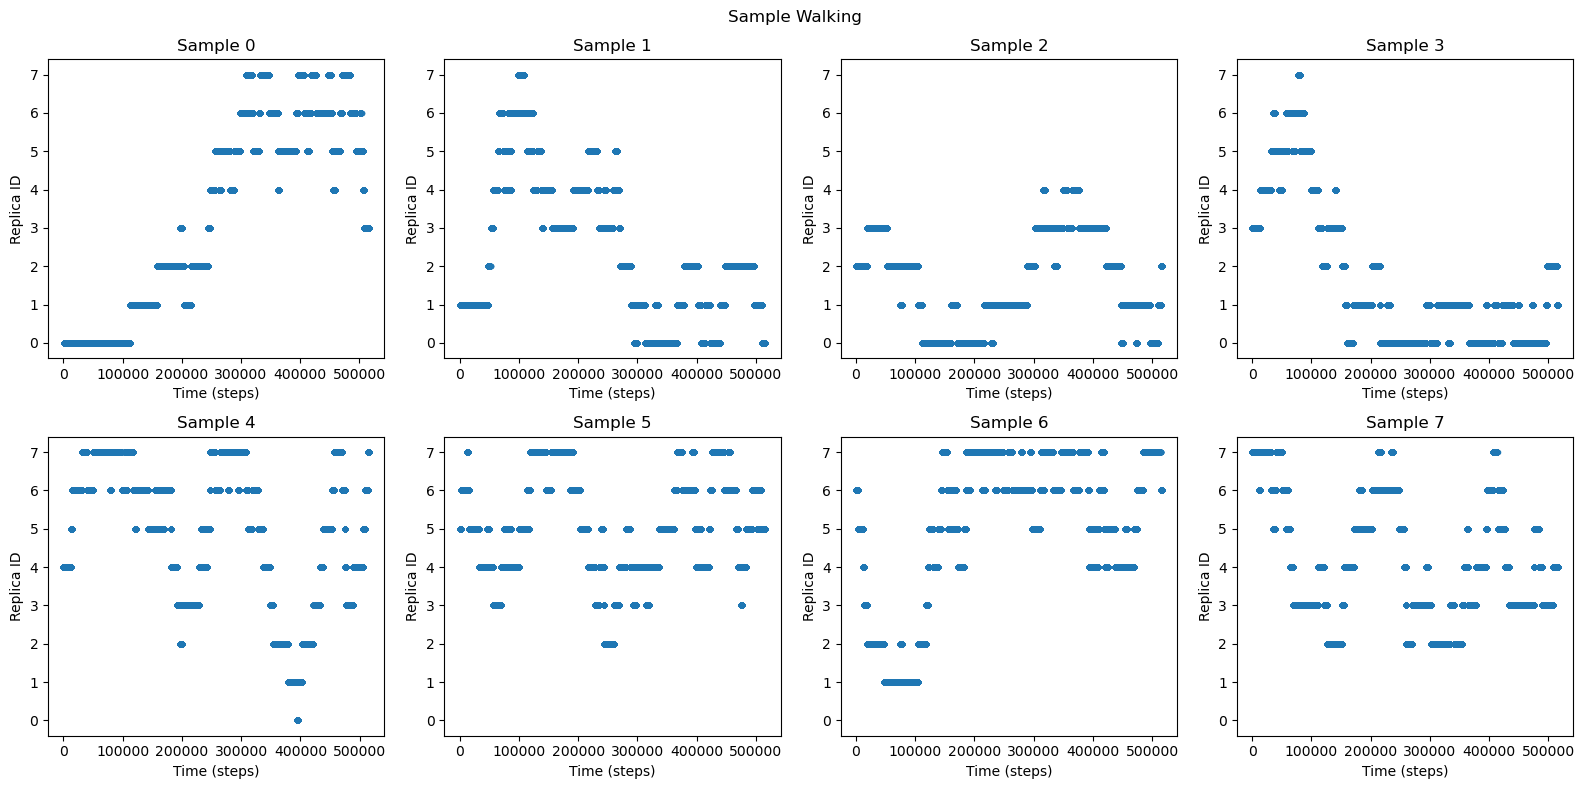

In [38]:
# runごとに時系列を見てみる
H = 2
W = 4
fig, axes = plt.subplots(H,W, figsize=(4*W, 4*H))
for i in range(params['n_replicas']):
    rep = np.where(replicas.to_numpy()==i)[1].repeat(params['n_steps_exchange'])
    axes[i//W][i%W].plot(rep-1, '.')
    axes[i//W][i%W].set_title(f'Sample {i}')
    axes[i//W][i%W].set_xlabel(f'Time (steps)')
    axes[i//W][i%W].set_ylabel(f'Replica ID')
    axes[i//W][i%W].set_ylim(0-params['n_replicas']*0.05, params['n_replicas']-1+params['n_replicas']*0.05)

fig.suptitle(f'Sample Walking')
fig.tight_layout()

fig.show()
# fig.savefig(f'{basedir}/potential_energy_{basename}.png', bbox_inches='tight')

## 交換確率を計算

In [41]:
acceptance = pd.read_csv(f'{output_dir}/acceptance.csv', header=0)
acceptance.head()

,step,replica1,replica2,acceptance
0,0,0,1,0
1,0,2,3,0
2,0,4,5,0
3,0,6,7,0
4,1000,1,2,0


### トラジェクトリ全長

In [44]:
print('Accept:', np.mean(acceptance['acceptance']==1)*100, '%')

Accept: 11.82857142857143 %


In [47]:
for i in range(0, params['n_replicas']-1, 1):
    print(f'Acceptance Ratio between {i} and {i+1}:', np.mean(acceptance[(acceptance['replica1']==i) & (acceptance['replica2']==i+1)]['acceptance']==1)*100, '%')

Acceptance Ratio between 0 and 1: 14.2 %
Acceptance Ratio between 1 and 2: 7.3999999999999995 %
Acceptance Ratio between 2 and 3: 6.2 %
Acceptance Ratio between 3 and 4: 9.0 %
Acceptance Ratio between 4 and 5: 12.6 %
Acceptance Ratio between 5 and 6: 15.4 %
Acceptance Ratio between 6 and 7: 18.0 %


### 交換確率の推移

In [54]:
acceptance_rates = pd.read_csv(f'{output_dir}/acceptance_rates.csv', header=0)
acceptance_rates.head()

,step,0_1,1_2,2_3,3_4,4_5,5_6,6_7
0,20000,0.0,0.0,0.090909,0.1,0.090909,0.2,0.181818
1,40000,0.0,0.0,0.000000,0.0,0.100000,0.2,0.200000
2,60000,0.0,0.1,0.100000,0.1,0.200000,0.2,0.100000
3,80000,0.0,0.2,0.000000,0.1,0.300000,0.3,0.200000
4,100000,0.0,0.0,0.000000,0.0,0.300000,0.3,0.100000


In [58]:
mean_acceptance_rates = np.mean(acceptance_rates.to_numpy()[:,1:], axis=1)
print(mean_acceptance_rates.shape)
print(mean_acceptance_rates)

(49,)
[0.09480519 0.07142857 0.11428571 0.15714286 0.1        0.15714286
 0.11428571 0.15714286 0.08571429 0.12857143 0.1        0.11428571
 0.14285714 0.11428571 0.12857143 0.14285714 0.1        0.05714286
 0.12857143 0.11428571 0.17142857 0.11428571 0.12857143 0.12857143
 0.08571429 0.15714286 0.1        0.11428571 0.14285714 0.05714286
 0.07142857 0.17142857 0.1        0.12857143 0.18571429 0.14285714
 0.18571429 0.08571429 0.08571429 0.08571429 0.12857143 0.14285714
 0.12857143 0.05714286 0.11428571 0.15714286 0.05714286 0.17142857
 0.1       ]


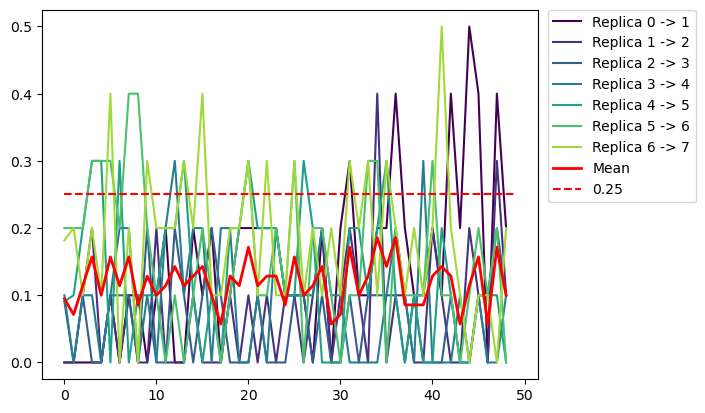

In [66]:
colors = plt.cm.viridis(np.linspace(0, 1, params['n_replicas']))

for i in range(0, params['n_replicas']-1):
    plt.plot(acceptance_rates[f'{i}_{i+1}'], label=f'Replica {i} -> {i+1}', color=colors[i])
plt.plot(mean_acceptance_rates, label='Mean', color='red', linewidth=2)
plt.hlines(params['acceptance_ratio'], 0, len(acceptance_rates), 'r', '--', label=params['acceptance_ratio'])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=10)
# plt.tight_layout()
plt.show()

### ログと一致するか確認
→ acceptance_ratesのログと、acceptanceで一から計算した結果があっていたのでOK

In [94]:
acceptance_rates.head()

,step,0_1,1_2,2_3,3_4,4_5,5_6,6_7
0,20000,0.0,0.0,0.090909,0.1,0.090909,0.2,0.181818
1,40000,0.0,0.0,0.000000,0.0,0.100000,0.2,0.200000
2,60000,0.0,0.1,0.100000,0.1,0.200000,0.2,0.100000
3,80000,0.0,0.2,0.000000,0.1,0.300000,0.3,0.200000
4,100000,0.0,0.0,0.000000,0.0,0.300000,0.3,0.100000


In [73]:
acceptance.head()

,step,replica1,replica2,acceptance
0,0,0,1,0
1,0,2,3,0
2,0,4,5,0
3,0,6,7,0
4,1000,1,2,0


In [82]:
params['n_replicas']

8

In [93]:
# acceptanceのstepが0以上20000以下のものの、acceptance列を平均する
acceptance_check = np.zeros((len(acceptance_rates), params['n_replicas']-1))
for i in range(0, len(acceptance_rates)-1):
    for j in range(0, params['n_replicas']-1):
        if i == 0:
            acceptance_check[i,j] = np.mean(acceptance[(acceptance['step']>=0) & (acceptance['step']<=acceptance_rates['step'][i]) & (acceptance['replica1']==j) & (acceptance['replica2']==j+1)]['acceptance'])
        acceptance_check[i+1,j] = np.mean(acceptance[(acceptance['step']>acceptance_rates['step'][i]) & (acceptance['step']<=acceptance_rates['step'][i+1]) & (acceptance['replica1']==j) & (acceptance['replica2']==j+1)]['acceptance'])

print(acceptance_check.shape)
print(acceptance_check)

(49, 7)
[[0.         0.         0.09090909 0.1        0.09090909 0.2
  0.18181818]
 [0.         0.         0.         0.         0.1        0.2
  0.2       ]
 [0.         0.1        0.1        0.1        0.2        0.2
  0.1       ]
 [0.         0.2        0.         0.1        0.3        0.3
  0.2       ]
 [0.         0.         0.         0.         0.3        0.3
  0.1       ]
 [0.1        0.1        0.1        0.1        0.         0.3
  0.4       ]
 [0.         0.         0.1        0.2        0.3        0.2
  0.        ]
 [0.1        0.1        0.1        0.2        0.         0.4
  0.2       ]
 [0.1        0.         0.         0.         0.1        0.4
  0.        ]
 [0.         0.         0.2        0.1        0.1        0.2
  0.3       ]
 [0.1        0.2        0.         0.         0.1        0.1
  0.2       ]
 [0.2        0.         0.         0.2        0.2        0.
  0.2       ]
 [0.         0.         0.2        0.3        0.2        0.1
  0.2       ]
 [0.         0.   

## 各温度のポテンシャルエネルギーの分布を見る

### 全体

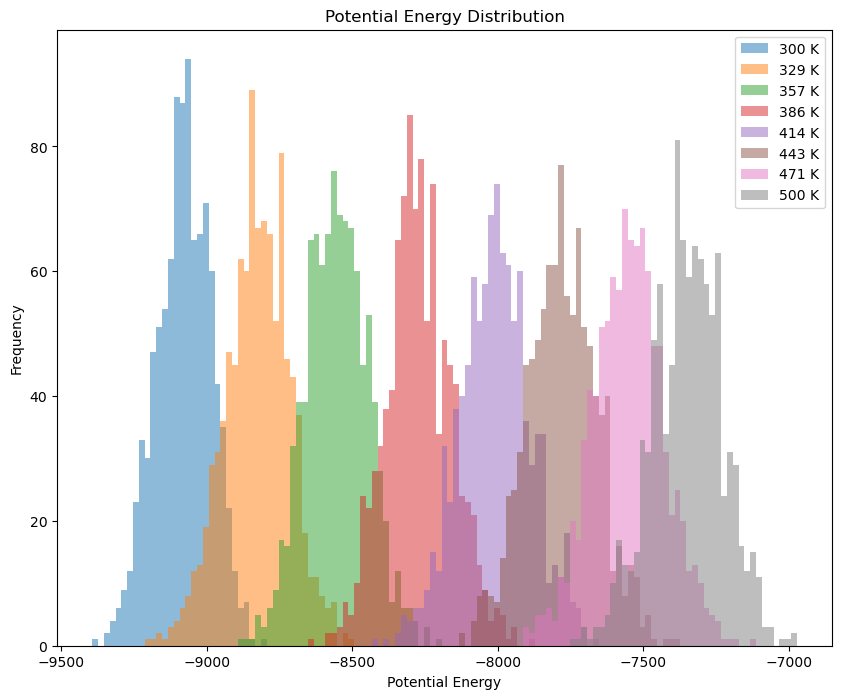

In [67]:
plt.figure(figsize=(10,8))
# max_potential = math.ceil(max(combined_df['potential_energy']))
# min_potential = math.floor(min(combined_df['potential_energy']))
# bins = np.arange(min_potential, max_potential+1, 10)
bins = np.arange(min(combined_df['potential_energy']), max(combined_df['potential_energy']), 20)

for i in range(params['n_replicas']):
    plt.hist(combined_df.loc[i]['potential_energy'], label=f'{params["temperatures"][i]:.0f} K', histtype='stepfilled', bins=bins, alpha=0.5)
plt.title('Potential Energy Distribution')
plt.xlabel('Potential Energy')
plt.ylabel('Frequency')
plt.legend()
plt.show()

/tmp/ipykernel_1538640/1309981400.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


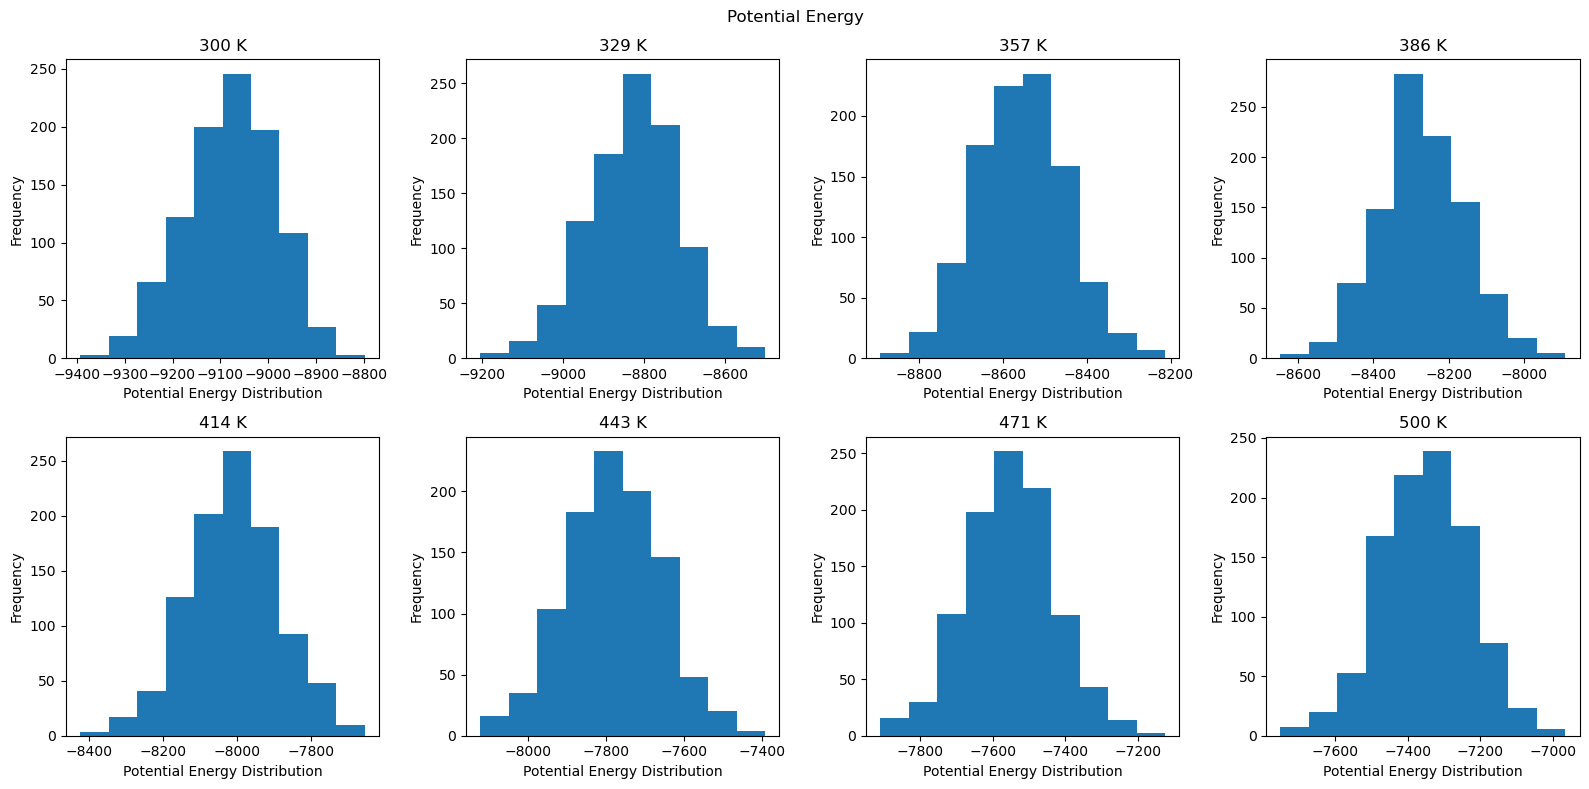

In [68]:
H = 2
W = 4
fig, axes = plt.subplots(H,W, figsize=(4*W, 4*H))
for i in range(params['n_replicas']):
    axes[i//W][i%W].hist(dfs[i]['potential_energy'])
    axes[i//W][i%W].set_title(f'{params["temperatures"][i]:.0f} K')
    axes[i//W][i%W].set_xlabel(f'Potential Energy Distribution')
    axes[i//W][i%W].set_ylabel(f'Frequency')

fig.suptitle(f'Potential Energy')
fig.tight_layout()

fig.show()
# fig.savefig(f'{basedir}/potential_energy_{basename}.png', bbox_inches='tight')

### 温度更新前のポテンシャルエネルギーの分布

In [69]:
print(params['n_steps'])
print(params['n_steps_adjust'])
print(params['n_steps_save'])

1000000
20000
500


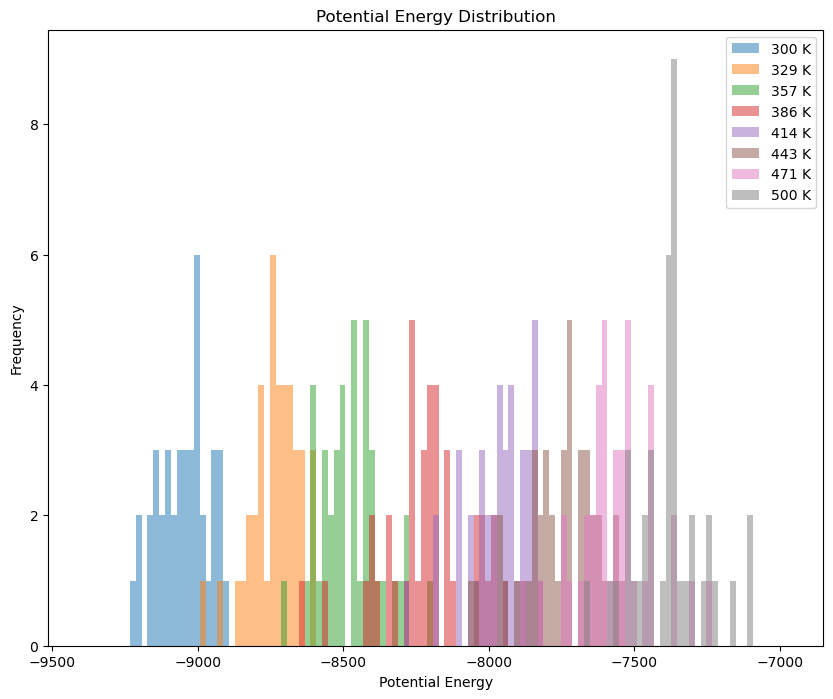

In [70]:
plt.figure(figsize=(10,8))
bins = np.arange(min(combined_df['potential_energy']), max(combined_df['potential_energy']), 20)

for i in range(params['n_replicas']):
    plt.hist(combined_df.loc[i]['potential_energy'][:params['n_steps_adjust']//params['n_steps_save']], label=f'{params["temperatures"][i]:.0f} K', histtype='stepfilled', bins=bins, alpha=0.5)
plt.title('Potential Energy Distribution')
plt.xlabel('Potential Energy')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### 温度更新後のポテンシャルエネルギーの分布

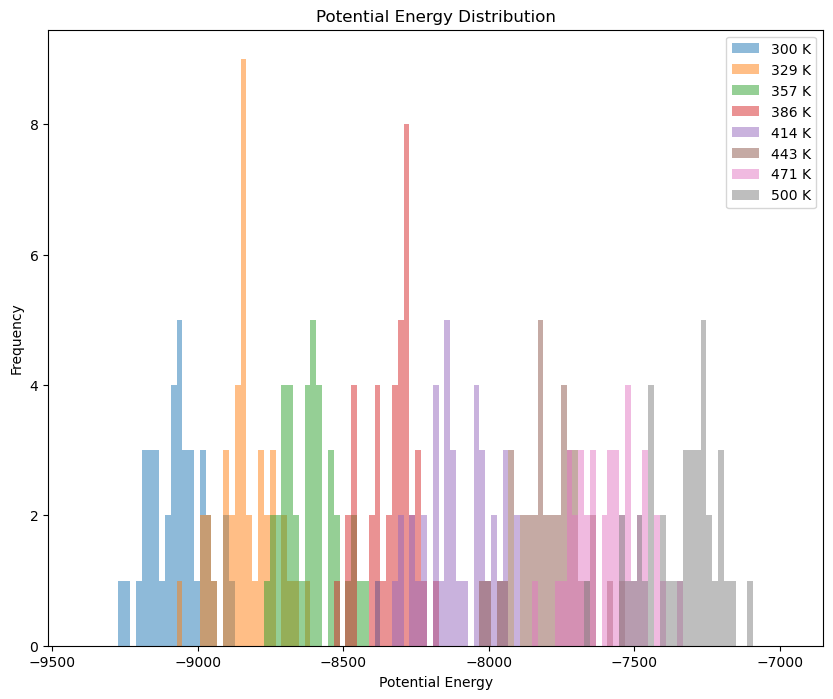

In [71]:
plt.figure(figsize=(10,8))
bins = np.arange(min(combined_df['potential_energy']), max(combined_df['potential_energy']), 20)

for i in range(params['n_replicas']):
    plt.hist(combined_df.loc[i]['potential_energy'][-params['n_steps_adjust']//params['n_steps_save']:], label=f'{params["temperatures"][i]:.0f} K', histtype='stepfilled', bins=bins, alpha=0.5)
plt.title('Potential Energy Distribution')
plt.xlabel('Potential Energy')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### 各温度レプリカのポテンシャルエネルギーの平均と分散を見る

In [27]:
avg = np.array([np.mean(dfs[i]['potential_energy']) for i in range(params['n_replicas'])])
std = np.array([np.std(dfs[i]['potential_energy']) for i in range(params['n_replicas'])])

print(f'Temp\tAverage\tStd')
for i in range(params['n_replicas']):
    print(f'{params["temperatures"][i]:.0f}\t{avg[i]:.0f}\t{std[i]:.0f}')

Temp	Average	Std
300	-9064	98
329	-8765	95
357	-8461	93
386	-8193	104
414	-7983	125
443	-7752	131
471	-7557	119
500	-7322	119


## 各レプリカのポテンシャルエネルギーの分布を見る

## 二面角で自由エネルギー地形プロット

In [28]:
trajs = [md.load(f'{output_dir}/replica_{i}.dcd', top=top) for i in tqdm(range(params['n_replicas']), leave=False)]

  0%|          | 0/8 [00:00<?, ?it/s]

In [132]:
print(md.compute_phi(trajs[i], periodic=True)[0])
print(md.compute_psi(trajs[i], periodic=True)[0])

[[ 4  6  8 14]]
[[ 6  8 14 16]]


In [133]:
# phi = np.rad2deg(np.array([md.compute_phi(trajs[i], periodic=True)[1].squeeze() for i in range(params['n_replicas'])]))
# psi = np.rad2deg(np.array([md.compute_psi(trajs[i], periodic=True)[1].squeeze() for i in range(params['n_replicas'])]))
phi = np.rad2deg(np.array([md.compute_dihedrals(trajs[i], [[4,6,8,14]], periodic=True).squeeze() for i in range(params['n_replicas'])]))
psi = np.rad2deg(np.array([md.compute_dihedrals(trajs[i], [[6,8,14,16]], periodic=True).squeeze() for i in range(params['n_replicas'])]))

In [134]:
phi.shape

(8, 200)

(-180.0, 180.0)

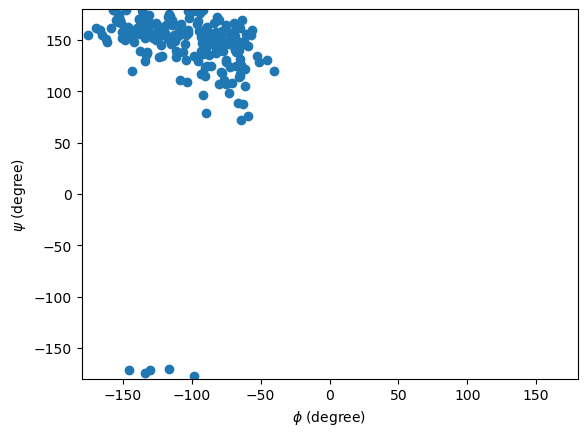

In [135]:
plt.scatter(phi[0], psi[0])
plt.xlabel('$\phi$ (degree)')
plt.ylabel('$\psi$ (degree)')
plt.xlim(-180,180)
plt.ylim(-180,180)

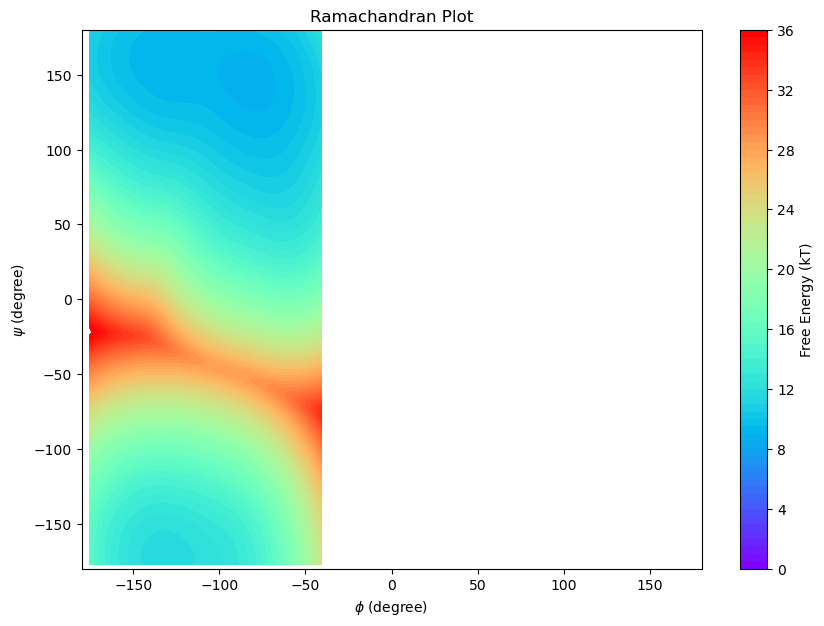

CPU times: user 5.5 s, sys: 154 ms, total: 5.66 s
Wall time: 284 ms


In [136]:
%%time
# Calculate the potential of mean force
kde = gaussian_kde(np.vstack([phi[0], psi[0]]))

# Compute the potential of mean force
x, y = np.mgrid[min(phi[0]):max(phi[0]):180j,
                min(psi[0]):max(psi[0]):180j]
positions = np.vstack([x.ravel(), y.ravel()])
pmf = np.reshape(kde(positions), x.shape)

# Plot the potential of mean force as contours on top of the scatter plot
plt.figure(figsize=(10, 7))
plt.contourf(x, y, -np.log(pmf), np.arange(0, (-np.log(pmf)).max(), 0.5), cmap='rainbow')
plt.colorbar(label='Free Energy (kT)')
plt.title('Ramachandran Plot')
plt.xlabel('$\phi$ (degree)')
plt.ylabel('$\psi$ (degree)')
plt.xlim(-180, 180)
plt.ylim(-180, 180)
plt.show()

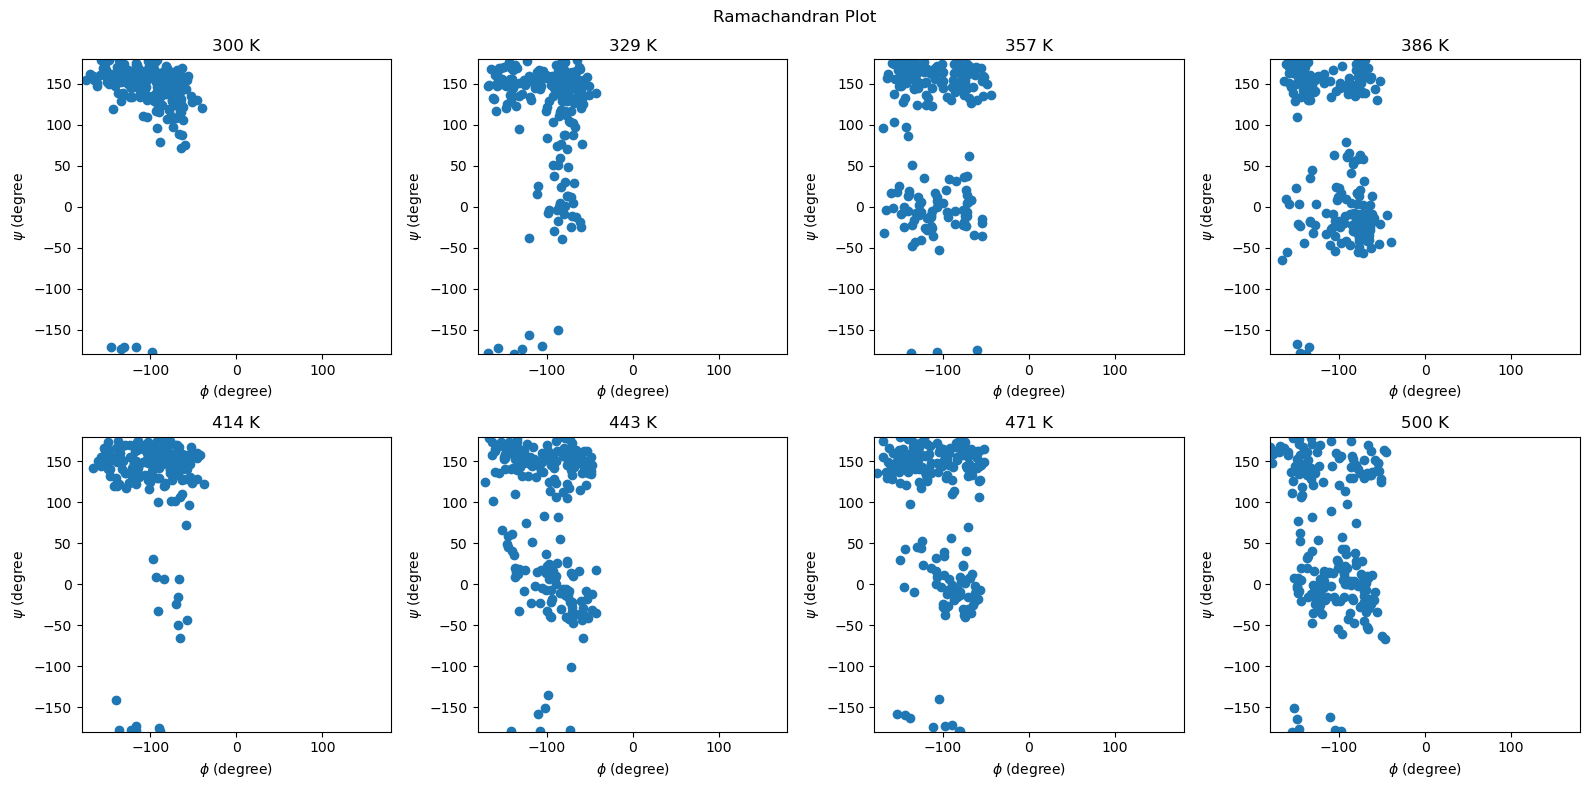

In [137]:
# runごとに時系列を見てみる
H = 2
W = 4
fig, axes = plt.subplots(H,W, figsize=(4*W, 4*H))
for i in range(params['n_replicas']):
    axes[i//W][i%W].scatter(phi[i], psi[i])
    axes[i//W][i%W].set_title(f'{params["temperatures"][i]:.0f} K')
    axes[i//W][i%W].set_xlabel('$\phi$ (degree)')
    axes[i//W][i%W].set_ylabel('$\psi$ (degree')
    axes[i//W][i%W].set_xlim(-180,180)
    axes[i//W][i%W].set_ylim(-180,180)

fig.suptitle(f'Ramachandran Plot')
fig.tight_layout()

fig.show()
# fig.savefig(f'{basedir}/potential_energy_{basename}.png', bbox_inches='tight')

CPU times: user 45.2 s, sys: 1.24 s, total: 46.5 s
Wall time: 2.36 s


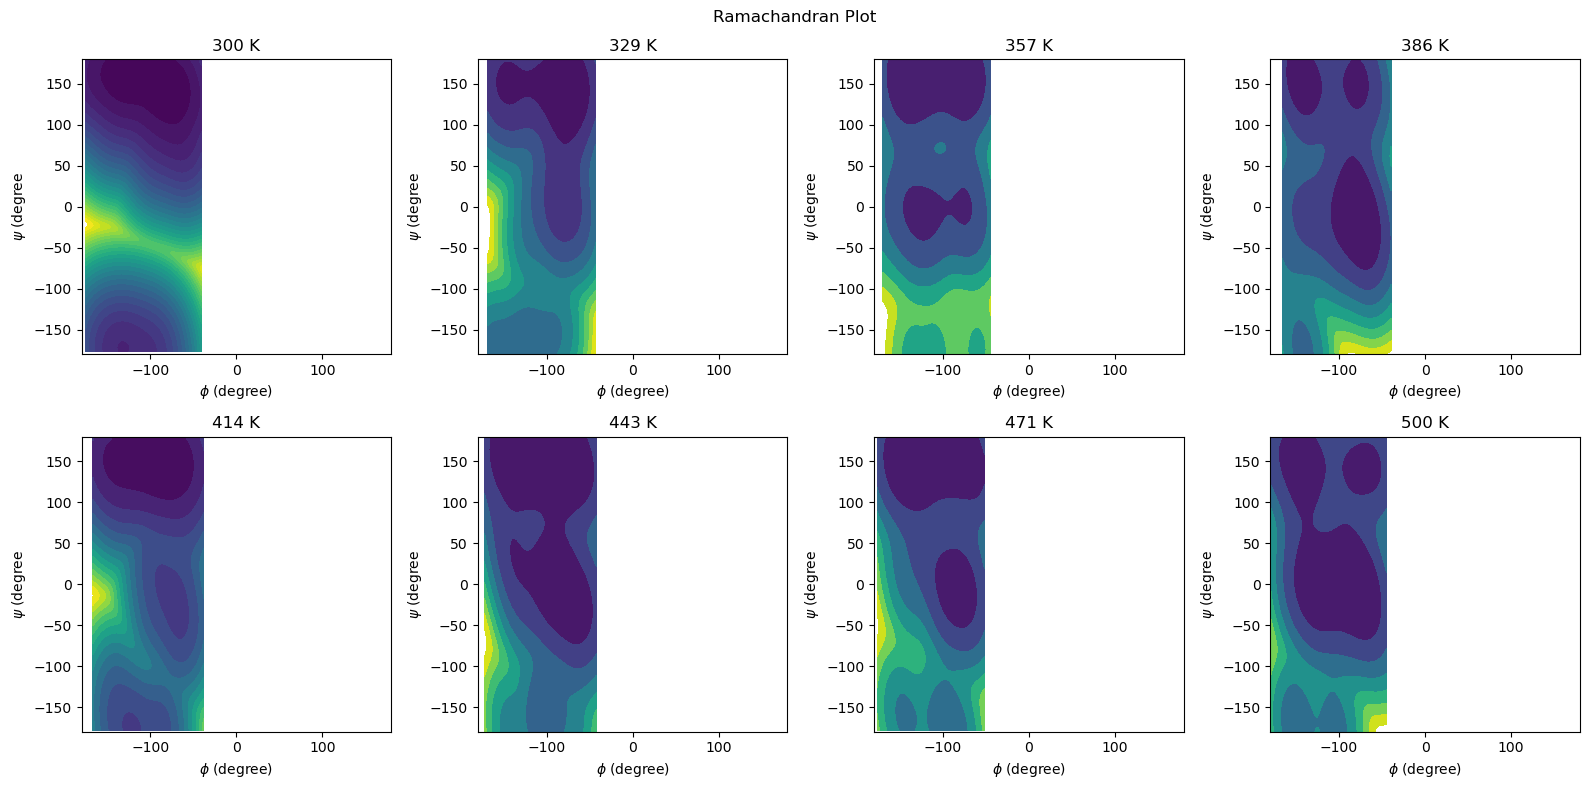

In [138]:
%%time
# runごとに時系列を見てみる
H = 2
W = 4
fig, axes = plt.subplots(H,W, figsize=(4*W, 4*H))
for i in range(params['n_replicas']):
    # Calculate the potential of mean force
    kde = gaussian_kde(np.vstack([phi[i], psi[i]]))
    
    # Compute the potential of mean force
    x, y = np.mgrid[min(phi[i]):max(phi[i]):360j,
                    min(psi[i]):max(psi[i]):360j]
    positions = np.vstack([x.ravel(), y.ravel()])
    pmf = np.reshape(kde(positions), x.shape)
    
    # Plot the potential of mean force as contours on top of the scatter plot
    axes[i//W][i%W].contourf(x, y, -np.log(pmf), np.arange((-np.log(pmf)).min(), (-np.log(pmf)).max(), 1), cmap='viridis')
    # axes[i//W][i%W].set_colorbar(label='Free Energy (kT)')
    axes[i//W][i%W].set_title(f'{params["temperatures"][i]:.0f} K')
    axes[i//W][i%W].set_xlabel('$\phi$ (degree)')
    axes[i//W][i%W].set_ylabel('$\psi$ (degree')
    axes[i//W][i%W].set_xlim(-180, 180)
    axes[i//W][i%W].set_ylim(-180, 180)

fig.suptitle(f'Ramachandran Plot')
fig.tight_layout()

fig.show()
# fig.savefig(f'{basedir}/potential_energy_{basename}.png', bbox_inches='tight')

## 別のやり方で自由エネルギー地形をプロット
- ChatGPTのコードを改造した。プロットの向きがおかしくなり手こずったが、m_gridをするとxyが転置されると考えればOK。
- 平滑化は、https://the-silkworms.com/matplotlib_scatter2d_1/4121/を参考にした。

(180, 180)
(180, 180)
(180, 180)
(180, 180)


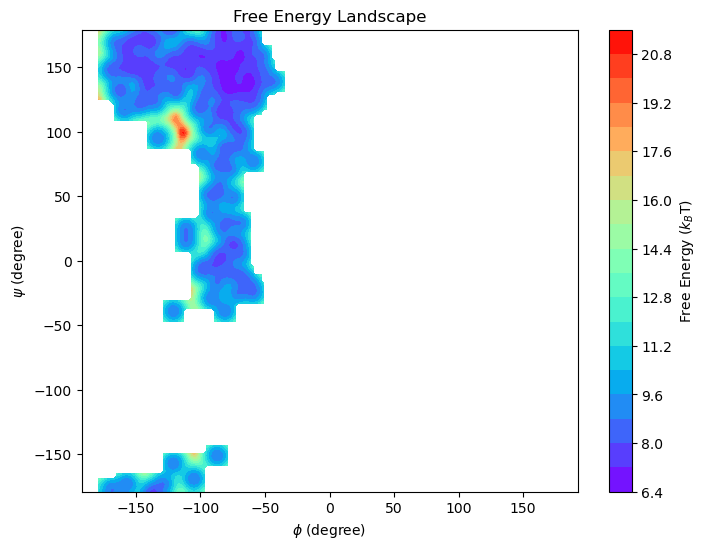

In [139]:
i = 1
x = phi[i]
y = psi[i]

# 2次元ヒストグラムを計算
hist, xedges, yedges = np.histogram2d(x, y, bins=180, range=[[-180, 180], [-180, 180]], density=True)

# 平滑化のチェック
hist_smooth = sp.ndimage.gaussian_filter(
    hist, [2,2], mode='nearest'
)

# 確率分布の正規化
prob_density = hist_smooth / np.sum(hist_smooth)

# 自由エネルギー計算 (k_B*Tを1として簡略化)
with np.errstate(divide='ignore'):  # 0の対数エラーを無視
    free_energy = -np.log(prob_density)
# free_energy = np.nan_to_num(free_energy, nan=np.max(free_energy))  # NaNを最大値で置換
print(free_energy.shape)

# 平滑化（オプション）
free_energy_smooth = gaussian_filter(free_energy, sigma=1)
# free_energy_smooth = sp.ndimage.gaussian_filter(
    # free_energy, [2,2], mode='nearest'
# )
print(free_energy_smooth.shape)

# メッシュグリッド作成
X, Y = np.meshgrid(
    (xedges[:-1] + xedges[1:]) / 2,  # ビンの中心
    (yedges[:-1] + yedges[1:]) / 2
)
print(X.shape)
print(Y.shape)

# 等高線プロット
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, free_energy_smooth.T, levels=20, cmap='rainbow')
plt.colorbar(contour, label='Free Energy ($k_B$T)')
plt.xlabel('$\phi$ (degree)')
plt.ylabel('$\psi$ (degree)')
plt.xlim(-180,180)
plt.ylim(-180,180)
plt.axis('equal')
plt.title('Free Energy Landscape')
plt.show()


In [140]:
def plot_free_energy(x, y, ax):
    # 2次元ヒストグラムを計算
    hist, xedges, yedges = np.histogram2d(x, y, bins=180, range=[[-180, 180], [-180, 180]], density=True)
    
    # 平滑化のチェック
    hist_smooth = sp.ndimage.gaussian_filter(
        hist, [2,2], mode='nearest'
    )
    
    # 確率分布の正規化
    prob_density = hist_smooth / np.sum(hist_smooth)
    
    # 自由エネルギー計算 (k_B*Tを1として簡略化)
    with np.errstate(divide='ignore'):  # 0の対数エラーを無視
        free_energy = -np.log(prob_density)
    # free_energy = np.nan_to_num(free_energy, nan=np.max(free_energy))  # NaNを最大値で置換
    
    # 平滑化（オプション）
    free_energy_smooth = gaussian_filter(free_energy, sigma=1)
    # free_energy_smooth = sp.ndimage.gaussian_filter(
        # free_energy, [2,2], mode='nearest'
    # )
    
    # メッシュグリッド作成
    X, Y = np.meshgrid(
        (xedges[:-1] + xedges[1:]) / 2,  # ビンの中心
        (yedges[:-1] + yedges[1:]) / 2
    )
    
    # 等高線プロット
    contour = ax.contourf(X, Y, free_energy_smooth.T, levels=20, cmap='rainbow')
    # ax.colorbar(contour, label='Free Energy (k_B T)')
    ax.set_xlim(-180,180)
    ax.set_ylim(-180,180)
    ax.set_aspect('equal')
    return contour

In [141]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

CPU times: user 386 ms, sys: 7.98 ms, total: 394 ms
Wall time: 392 ms


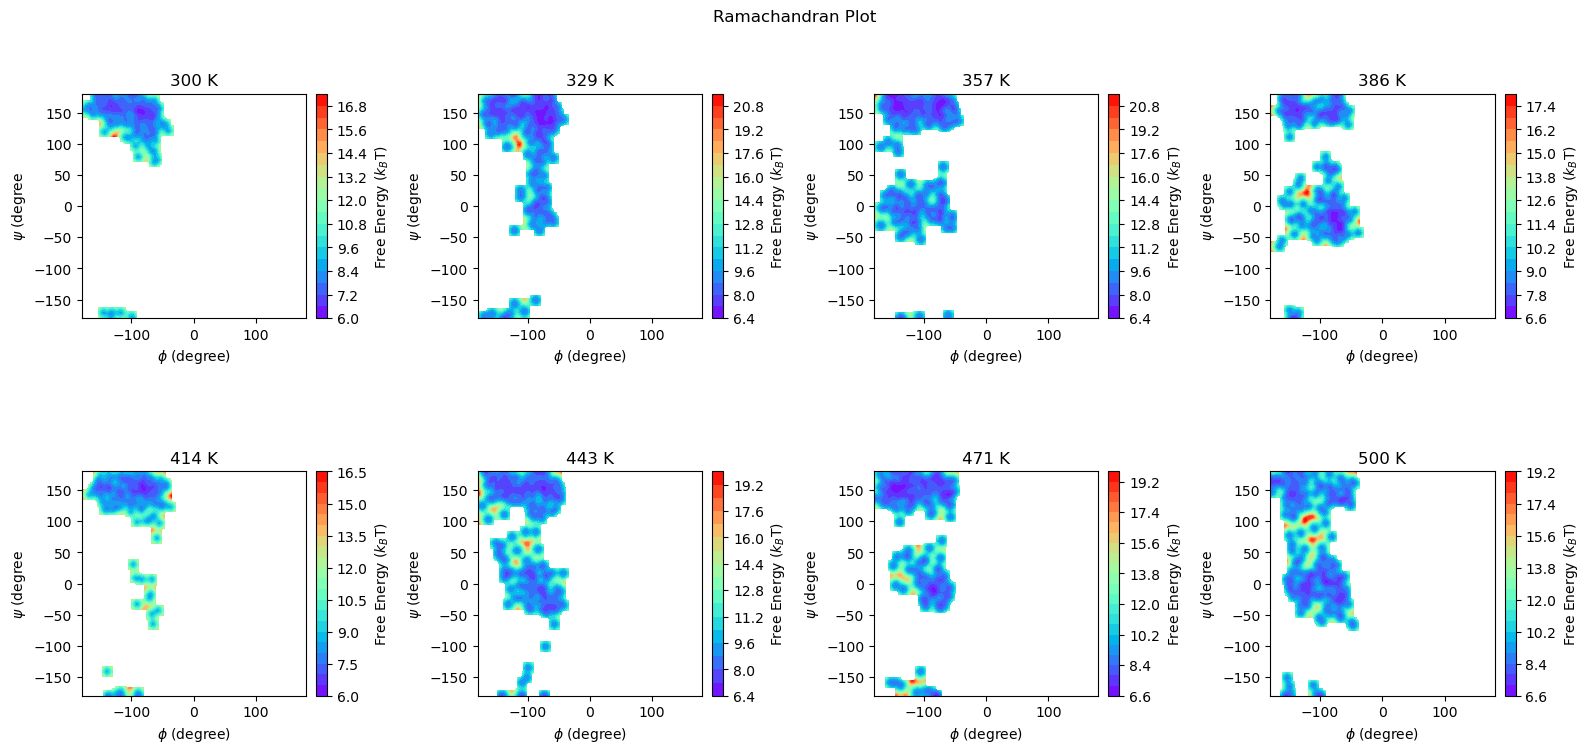

In [142]:
%%time
# runごとに時系列を見てみる
H = 2
W = 4
fig, axes = plt.subplots(H,W, figsize=(4*W, 4*H))
for i in range(params['n_replicas']):
    contour = plot_free_energy(phi[i], psi[i], axes[i//W][i%W])
    divider = make_axes_locatable(axes[i//W][i%W])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(contour, ax=axes[i//W][i%W], label='Free Energy ($k_B$T)', cax=cax, cmap="binary_r")
    # cbar = fig.colorbar()
    axes[i//W][i%W].set_title(f'{params["temperatures"][i]:.0f} K')
    axes[i//W][i%W].set_xlabel('$\phi$ (degree)')
    axes[i//W][i%W].set_ylabel('$\psi$ (degree')

fig.suptitle(f'Ramachandran Plot')
fig.tight_layout()

fig.show()
# fig.savefig(f'{basedir}/potential_energy_{basename}.png', bbox_inches='tight')